# Evaluation Eval Data

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from nltk.tokenize import word_tokenize
from typing import *
from sklearn import preprocessing
from joblib import dump, load

In [13]:
sys.path.append("../")
from rs_helper import DAN,EmbeddingModel, FastTextWrapper, read_data, Batches, confusion_matrix_plot
from rs_helper.core.EmbeddingModel.FastTextWrapper import FastTextWrapper
from rs_helper.core.EmbeddingModel.DAN import DAN


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.colors
from sklearn.metrics.pairwise import cosine_similarity

In [79]:
data_valid = "../datasets/eval_data"

In [80]:
df_valid = read_data(data_valid)

In [81]:
df_valid.head()

,url,text,class
0,C:\Users\Daniel\PycharmProjects\Recommender-Sy...,I want to group my machines according to their...,clustering
1,C:\Users\Daniel\PycharmProjects\Recommender-Sy...,Identifying groups of motor insurance policy h...,clustering
2,C:\Users\Daniel\PycharmProjects\Recommender-Sy...,I want to identify workout sessions that are s...,clustering
3,C:\Users\Daniel\PycharmProjects\Recommender-Sy...,I want to extract a set of colours from an ima...,clustering
4,C:\Users\Daniel\PycharmProjects\Recommender-Sy...,As a grocery store we want to group our 1.3MM ...,clustering


In [63]:
ft_model = FastTextWrapper("ft_models/fasttext_12/model.joblib")

INFO:tensorflow:FastText Model is loading
INFO:tensorflow:FastText Model loaded!


In [64]:
dan = DAN(ft_model, "../models/DANs/1/frozen_graph.pb")

In [82]:
df_valid["tokenized"] = df_valid["text"].apply(lambda x: word_tokenize(x))
df_valid["embedding"] = dan.inference_batches(df_valid["tokenized"].tolist())
df_valid["embedding"] = df_valid["embedding"].apply(lambda x: x[0])

In [77]:
def scatter_plot(embedding_model: EmbeddingModel,
                 text: List[str],
                 labels: List[Any],
                 urls: List[Any],
                 save_dir: str = None,
                 fig_title: str = "",
                 ax_title: str = "",
                 colors: List[str] = ["#EF4836", "#FDB50A", "#00678F"]):
    if len(labels) != len(text):
        raise ValueError("List of text and labels need to have the same len")
    if len(colors) < len(set(labels)):
        raise ValueError("You need to provide the at least the same amount of cmaps as classes in the data: {}".format(
            len(set(text))))

    df = pd.DataFrame.from_dict({"text": [word_tokenize(x) for x in text], "label": labels, "url": urls})
    if isinstance(embedding_model, DAN):
        df["embedding"] = embedding_model.inference_batches(df["text"].tolist())
    else:
        df["embedding"] = df["text"].apply(lambda x: embedding_model.inference(x))
        df["embedding"] = df["embedding"].apply(lambda x: np.mean(x, axis=0))
    # df["embedding"] = df["text"].apply(lambda x: embedding_model.inference(word_tokenize(x))[0])
    # PCA
    # print(df["embedding"])
    pca = PCA(n_components=2)

    if isinstance(embedding_model, DAN):
        matrix = pca.fit_transform(df["embedding"].apply(lambda x: x[0]).tolist())

    else:
        matrix = pca.fit_transform(df["embedding"].tolist())
    explained_variance = pca.explained_variance_ratio_.cumsum()

    df["x"] = matrix[:, 0]
    df["y"] = matrix[:, 1]
    # Plot
    groups = df.groupby("label")

    fig = plt.figure(figsize=(12, 10))
    fig.suptitle(fig_title)

    ax_1 = fig.add_subplot(1, 1, 1)
    ax_1.set_title(ax_title)

    labels = []

    for i, (class_name, _df) in enumerate(groups):
        ax_1.scatter(_df["x"], _df["y"], c=colors[i], alpha=0.4)
        labels.append(mpatches.Patch(color=colors[i], label=class_name))
        
    # line1 = Line2D(range(10), range(10), marker='o', color="goldenrod")
        for _,row in _df.iterrows():
            
            ax_1.annotate(os.path.basename(row["url"]), (row["x"], row["y"]))
        print(str(explained_variance))
            
    legend = plt.legend(handles=labels)

    if save_dir is not None and os.path.isdir(save_dir):
        plt.savefig(os.path.join(save_dir, "scatter.png"))
        plt.savefig(os.path.join(save_dir, "scatter.svg"))

    # TODO Remove this later

    # plt.savefig(os.path.join("output_scatter/png/", "{}.png".format(str(ax_title))))
    # plt.savefig(os.path.join("output_scatter/svg/", "{}.svg".format(str(ax_title))))
    return ax_1

[0.64514828 0.90021935]
[0.64514828 0.90021935]
[0.64514828 0.90021935]


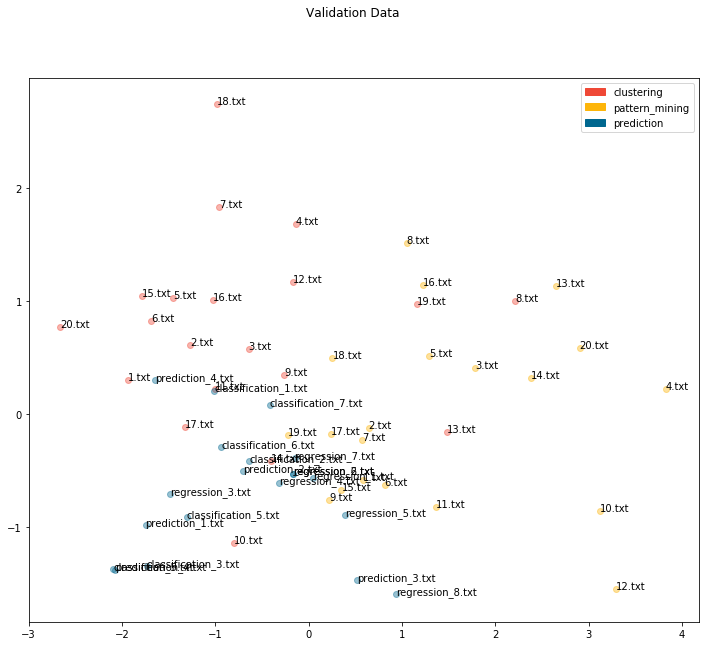

In [83]:
ax_2 = scatter_plot(dan, df_valid["text"].tolist(), df_valid["class"].tolist(),df_valid["url"].tolist(), fig_title = "Validation Data")

[0.16101202 0.25679066]
[0.16101202 0.25679066]
[0.16101202 0.25679066]


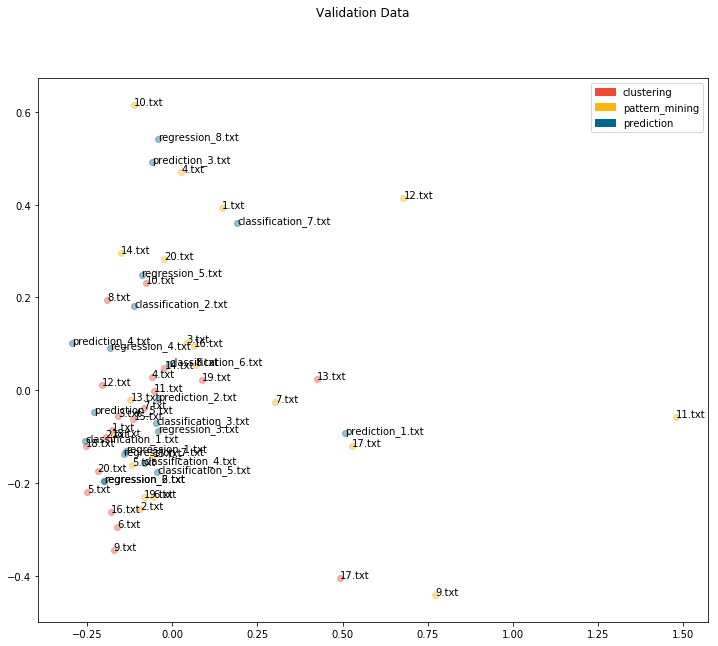

In [54]:
ax_2 = scatter_plot(ft_model, df_valid["text"].tolist(), df_valid["class"].tolist(),df_valid["url"].tolist(), fig_title = "Validation Data")